In [ ]:
import pandas as pd
# from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import math
from itertools import product
%matplotlib inline

In [ ]:
def statistical_summary(dataframe: pd.DataFrame):
    """
    This function provides a general statistical summary

    args:
        dataframe (pd.DataFrame): target Dataframe

    output:
        dataframe (pd.DataFrame): Dataframe descriptive statistics

    Example usage:
        statistical_summary(dataframe = dataframe)
    """
    # Splitting numerical from categorical data
    num_attributes = dataframe.select_dtypes( include=['int64', 'float64','int32', 'float32'] )

    # Central Tendency - Mean, Median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

    # coefficient of variation
    cv1 = d1/ct1

    # Putting all together
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6,cv1] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'var_coef']
    return m;

def correlation_matrix(dataframe: pd.DataFrame):
    """
    This function computes and plots a correlation matrix for all numerical columns.

    Args:
        dataframe (pd.DataFrame): DataFrame containing data of interest.

    Returns:
        None (displays a heatmap based on correlation matrix)

    Example usage:
        correlation_matrix(dataframe=dataframe)
    """
    # Select numerical columns
    num_cols = dataframe.select_dtypes(include=['int64', 'float64','int32', 'float32']).columns

    # Create correlation matrix
    corr_matrix = dataframe[num_cols].corr()

    # Create a mask to hide upper triangle of the plot
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap=cmap,
        center=0,
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .5},
        annot=True,
        fmt='.2f',
        annot_kws={"size": 10}
    )

    # Set x- and y-axis label rotations
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.title('Correlation Matrix', fontsize=14)

    plt.tight_layout()
    return plt.show()


def plot_categorical_features(dataframe: pd.DataFrame,
                              ncols: int = 3,
                              figsize: tuple = (15, 5),
                              plot_type: str ='countplot',
                              **kwargs):
    """
    Plots bar plots of categorical columns of a dataframe.

    Args
        dataframe (pd.DataFrame): dataframe of interest
    ncols (int): number of columns in the plot grid (default = 3)
    figsize (tuple): size of the figure (default = (15, 5))
    plot_type (str): Type of plot to use (default = 'countplot')
    **kwargs: Keyword arguments to be passed to the seaborn countplot/barplot function.

    Returns:
        None

    Example usage:
        plot_categorical_features(dataframe = dataframe,
                                    ncols = 3,
                                    figsize = (15, 5),
                                    plot_type = 'countplot')
    """
    # Keeping only categorical values
    cat_attributes = dataframe.select_dtypes( exclude = ['int64', 'float64','int32', 'float32','datetime64[ns]'])

    # setting number of rows
    if cat_attributes.shape[1] <= ncols:
        nrows = 1
    else:
        nrows = int(np.floor(cat_attributes.shape[1]/ncols))+1

    # Plotting data
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    for i, col in enumerate(cat_attributes):
        ax = axes.flat[i]
        if plot_type == 'countplot':
            sns.countplot(x = col, data = dataframe, ax = ax, **kwargs)
        elif plot_type == 'barplot':
            sns.barplot(x = col, y = 'count',
                        data = dataframe.groupby(col).size().reset_index(name = 'count'),
                        ax = ax, **kwargs)
        ax.set_title(col)

    # Returning figure
    plt.tight_layout()
    return plt.show();

def plot_categorical_heatmap(dataframe:pd.DataFrame,
                             figsize:tuple =(10, 8)):
    """
    Plots a heatmap of the counts of different categories for each pair of categorical variables in the input data frame.

    Args:
        data (pd.DataFrame): input data frame containing the categorical variables to plot
        figsize (tuple): figure size to use for the plot. (default = (10, 8))

    Returns:
        None

    Example usage:
        plot_categorical_heatmap(dataframe = dataframe,
                                figsize=(10, 8))

    """

    # Keeping only categorical variables
    cat_attributes = dataframe.select_dtypes( exclude=['int64', 'float64','int32', 'float32','datetime64[ns]'])
    cols = cat_attributes.columns

    # Empy data frame to be filled
    counts = pd.DataFrame(0, index=cols, columns=cols)

    # Compute the counts for each pair of categorical variables
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i == j:
                counts.at[col1, col2] = dataframe[col1].count()
            else:
                counts.at[col1, col2] = dataframe.groupby([col1, col2]).size().shape[0]
    # Plot the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(counts,
                     annot=True,
                     cmap='Blues')
    ax.set_title('Categorical Variables Heatmap')
    return plt.show();

def plot_clustered_bars(dataframe: pd.DataFrame, figsize: tuple = None):
    """
    Creates a clustered bar chart for each combination of categorical variables in a pandas dataframe.
    Produces 5 columns and as many rows as needed, and includes a legend for the color convention.

    Args:
        dataframe (pd.DataFrame): Input dataframe with categorical variables
        figsize (tuple): Figure size for the plot (width, height).
                         If None, a default is computed based on the number of rows needed.

    Returns:
        None
    """
    # Identify categorical columns
    cat_vars = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
    if not cat_vars:
        print("[Info] No categorical variables in input dataframe.")
        return None

    # Number of categorical variables
    num_vars = len(cat_vars)
    # Total number of subplots = for each pair (var1, var2)
    num_plots = num_vars * num_vars

    # We fix 5 columns and calculate the number of rows needed
    ncols = 5
    nrows = math.ceil(num_plots / ncols)

    # If no figsize is given, choose a default that scales with rows
    if figsize is None:
        figsize = (4 * ncols, 4 * nrows)

    # Create the subplot grid
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    # Flatten axes to a 1D array for easy indexing
    axes = axes.flatten()

    # Generate the clustered bar charts
    for idx, (var1, var2) in enumerate(product(cat_vars, cat_vars)):
        ax = axes[idx]

        if var1 == var2:
            # Single variable countplot (no hue)
            sns.countplot(x=var1, data=dataframe, ax=ax)
            ax.set_xlabel('')
            ax.set_title(f"{var1}")
        else:
            # Clustered countplot with hue
            sns.countplot(x=var1, hue=var2, data=dataframe, ax=ax)
            # Optionally set legend title to the hue variable for clarity
            ax.legend(title=var2)
            ax.set_title(f"{var1} vs {var2}")

        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots if the grid is larger than num_plots
    for ax in axes[num_plots:]:
        ax.set_visible(False)

    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()

def plot_categorical_numerical_interactions(dataframe: pd.DataFrame,
                                            plot_type: str = 'violin'):
    """
    Plots the interaction between each categorical variable and each numerical variable
    in a dataframe. Displays all plots in a grid of 5 columns and as many rows as needed.

    Args:
        dataframe (pd.DataFrame): Input dataframe containing categorical and numerical variables.
        plot_type (str): Type of figure to be used ('boxplot' or 'violin'). Default is 'violin'.

    Returns:
        None
    """
    # Identify categorical and numerical columns
    cat_vars = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
    num_vars = dataframe.select_dtypes(include=['int', 'float']).columns.tolist()

    # Check that we have at least one categorical and one numerical column
    if not cat_vars or not num_vars:
        print("[Info] Dataframe must have at least one categorical and one numerical column.")
        return

    # Generate all (numerical, categorical) pairs
    pairs = list(product(num_vars, cat_vars))
    num_plots = len(pairs)  # total number of subplots

    # Fixed number of columns = 5; compute the required number of rows
    ncols = 5
    nrows = math.ceil(num_plots / ncols)

    # Set a default figure size if none provided (you can tweak the multipliers)
    figsize = (5 * ncols, 4 * nrows)

    # Create the subplot grid and flatten the axes
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # Iterate over each (num_var, cat_var) pair
    for idx, (num_var, cat_var) in enumerate(pairs):
        ax = axes[idx]

        # Plot the chosen plot_type
        if plot_type == 'violin':
            sns.violinplot(x=cat_var, y=num_var, data=dataframe, ax=ax)
        elif plot_type == 'boxplot':
            sns.boxplot(x=cat_var, y=num_var, data=dataframe, ax=ax)
        else:
            raise ValueError("plot_type must be 'violin' or 'boxplot'")

        ax.set_title(f"{cat_var} vs {num_var}", fontsize=10)
        ax.tick_params(axis='x', rotation=45)  # rotate x-axis labels for readability

    # Hide any unused subplots if the grid is larger than num_plots
    for ax in axes[num_plots:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

def scatterplot_matrix_numeric(dataframe:pd.DataFrame,
                               more_than_two_values: bool = True):
    """Creates a scatterplot matrix for all pairs of numerical variables in the input dataframe.

    Arg:
        dataframe (pd.DataFrame): input data frame
        more_than_two_values (bool): flag to keep variables with more than two values (default = True)

    Returns:
        None

    Example usage:
        scatterplot_matrix_numeric(dataframe = dataframe)
    """

    # Get numerical variables
    num_vars = dataframe.select_dtypes(include = ['int64', 'float64','int32', 'float32']).columns.tolist()

    # Making sure there are numerical variables
    if not num_vars:
        print("No numerical variables in input dataframe")
        return None;

    # Create scatterplot matrix
    sns.set(style='ticks')
    if more_than_two_values:
        num_var_2 = [var for var in num_vars if len(list(dataframe[var].unique())) > 2]
        sns.pairplot(dataframe[num_var_2],
                     diag_kind ='kde')
    else:
        sns.pairplot(dataframe[num_vars],
                    diag_kind ='kde')

    # Rotate x-axis and y-axis tick labels
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)

    return plt.show();

def features_vs_binary_target(dataframe: pd.DataFrame,
                              target_variable:str):
    """
    Plot the relationship between each feature column and the binary target variable.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing the feature and target columns.
        target_variable (str): The name of the column containing the binary target variable.

    Returns:
        None

    Example usage:
        utils.features_vs_binary_target(dataframe = dataframe,
                                        target_variable = 'response')

    """

    # target_variable is the column containing the binary target variable

    num_features = len(dataframe.columns) - 1  # Subtract 1 to exclude the target column
    num_rows = math.ceil(num_features / 3)  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    row = 0
    col = 0

    # Iterate over each feature column
    for i, feature_column in enumerate(dataframe.columns):
        if feature_column == target_variable:
            continue  # Skip the response column

        ax = axes[row, col] if num_rows > 1 else axes[col]  # Get the current axis

        if col == 2:
            col = 0
            row += 1
        else:
            col += 1

        # Generate the appropriate plot based on the column type
        if dataframe[feature_column].dtype == 'object':
            sns.countplot(x=feature_column, hue=target_variable, data=dataframe, ax=ax)
        else:
            sns.histplot(data=dataframe, x=feature_column, hue=target_variable, multiple='stack', ax=ax)

        ax.set_title(feature_column)

    # Remove empty subplots
    if num_features % 3 != 0:
        for i in range(num_features % 3, 3):
            fig.delaxes(axes[row, i] if num_rows > 1 else axes[i])

    plt.tight_layout()
    plt.show()


def plot_feature_vs_target(dataframe: pd.DataFrame,
                           target_variable: str):
    """
    Plot the relationship between each feature variable and the target variable.

    For variables with less than 50 unique values, create percentage bar plots.
    For variables with more than 50 unique values, create overlapped histograms.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing the feature and target variables.
        target_variable (str): The name of the target variable column.

    Returns:
        None

    """
    num_features = len(dataframe.columns) - 1  # Subtract 1 to exclude the target column
    num_rows = math.ceil(num_features / 3)  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    row = 0
    col = 0

    # Iterate over each feature column
    for i, feature_column in enumerate(dataframe.columns):
        if feature_column == target_variable:
            continue  # Skip the target variable column

        ax = axes[row, col] if num_rows > 1 else axes[col]  # Get the current axis

        if col == 2:
            col = 0
            row += 1
        else:
            col += 1

        unique_values = dataframe[feature_column].nunique()

        # Generate the appropriate plot based on the number of unique values
        if unique_values <= 50:
            sns.barplot(x = feature_column,
                        y = target_variable,
                        data = dataframe,
                        estimator = lambda x: len(x) / len(dataframe) * 100,
                        ax=ax)
            ax.set_title(f"{feature_column} vs {target_variable} (Percentage Bar Plot)")
            ax.set_ylabel("Percentage")
            plt.legend(frameon=False, ncol=2)
        else:
            sns.histplot(data = dataframe,
                         x = feature_column,
                         hue = target_variable,
                         multiple = 'stack',
                         kde = True,
                         ax = ax)
            ax.set_title(f"{feature_column} vs {target_variable} (Overlapped Histogram)")
            plt.legend(frameon=False, ncol=2)

    # Remove empty subplots
    if num_features % 3 != 0:
        for i in range(num_features % 3, 3):
            fig.delaxes(axes[row, i] if num_rows > 1 else axes[i])

    plt.tight_layout()
    plt.show()

In [ ]:
dataframe = pd.read_csv('bank-full.csv', sep = ';')

In [ ]:
statistical_summary(dataframe = dataframe)

attributes     min       max     range         mean  median          std  \
0        age    18.0      95.0      77.0    40.936210    39.0    10.618645   
1    balance -8019.0  102127.0  110146.0  1362.272058   448.0  3044.732156   
2        day     1.0      31.0      30.0    15.806419    16.0     8.322384   
3   duration     0.0    4918.0    4918.0   258.163080   180.0   257.524964   
4   campaign     1.0      63.0      62.0     2.763841     2.0     3.097987   
5      pdays    -1.0     871.0     872.0    40.197828    -1.0   100.127639   
6   previous     0.0     275.0     275.0     0.580323     0.0     2.303416   

        skew     kurtosis  var_coef  
0   0.684818     0.319570  0.259395  
1   8.360308   140.751547  2.235040  
2   0.093079    -1.059897  0.526519  
3   3.144318    18.153915  0.997528  
4   4.898650    39.249651  1.120899  
5   2.615715     6.935195  2.490872  
6  41.846454  4506.860660  3.969193

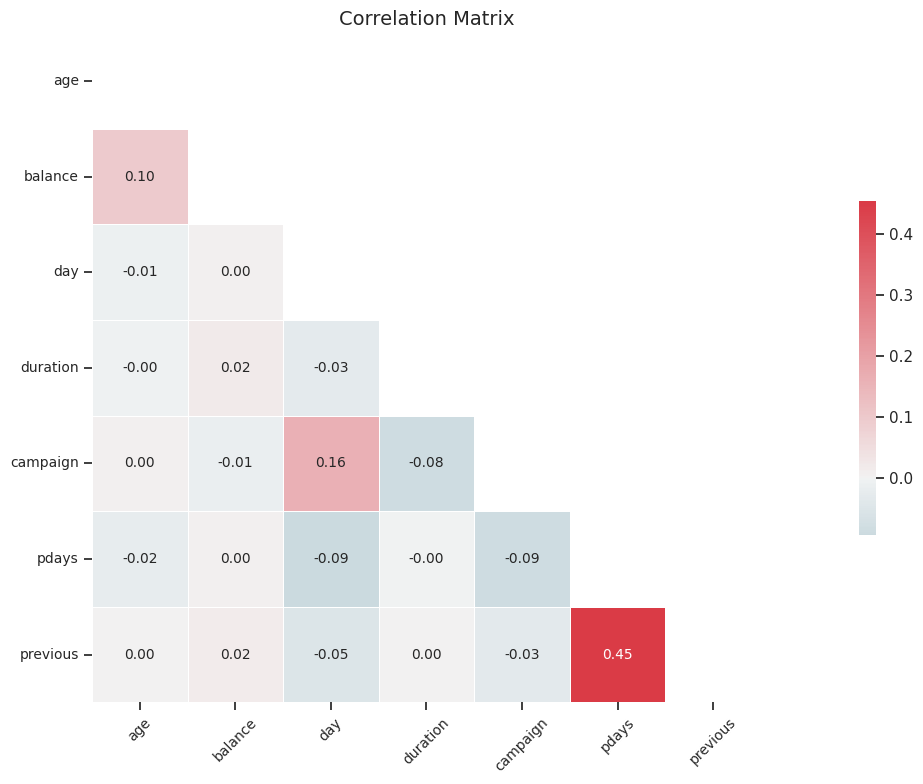

In [ ]:
correlation_matrix(dataframe = dataframe)

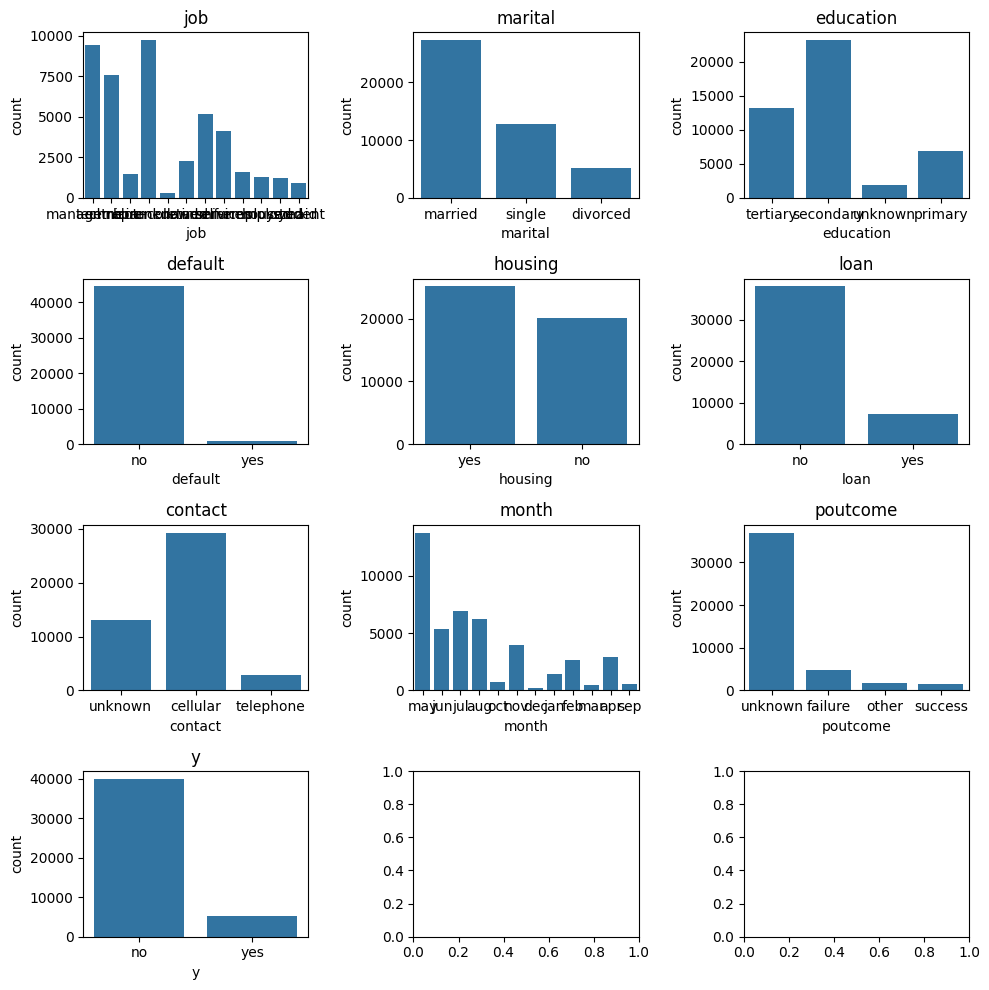

In [ ]:
plot_categorical_features(dataframe = dataframe, figsize = (10,10))

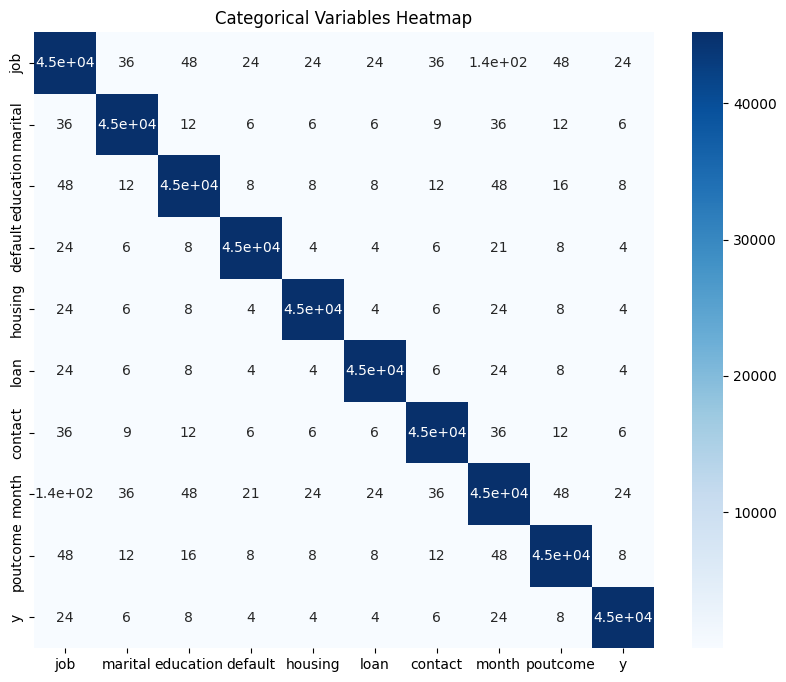

In [ ]:
plot_categorical_heatmap(dataframe = dataframe)

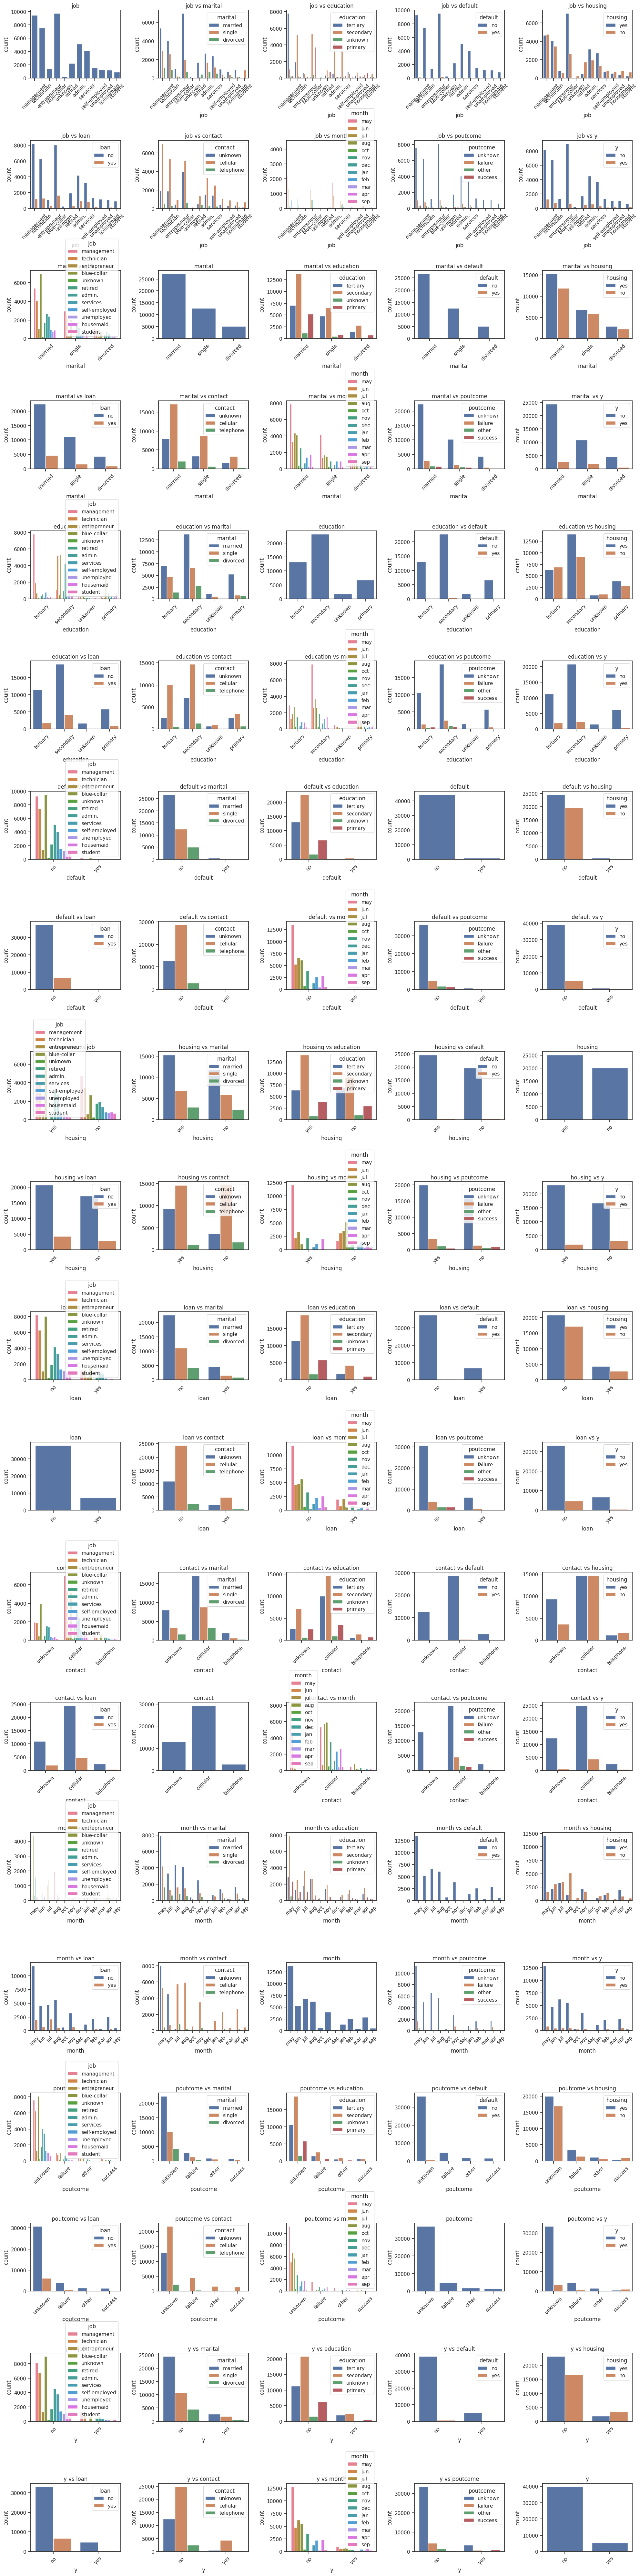

In [ ]:
plot_clustered_bars(dataframe = dataframe)

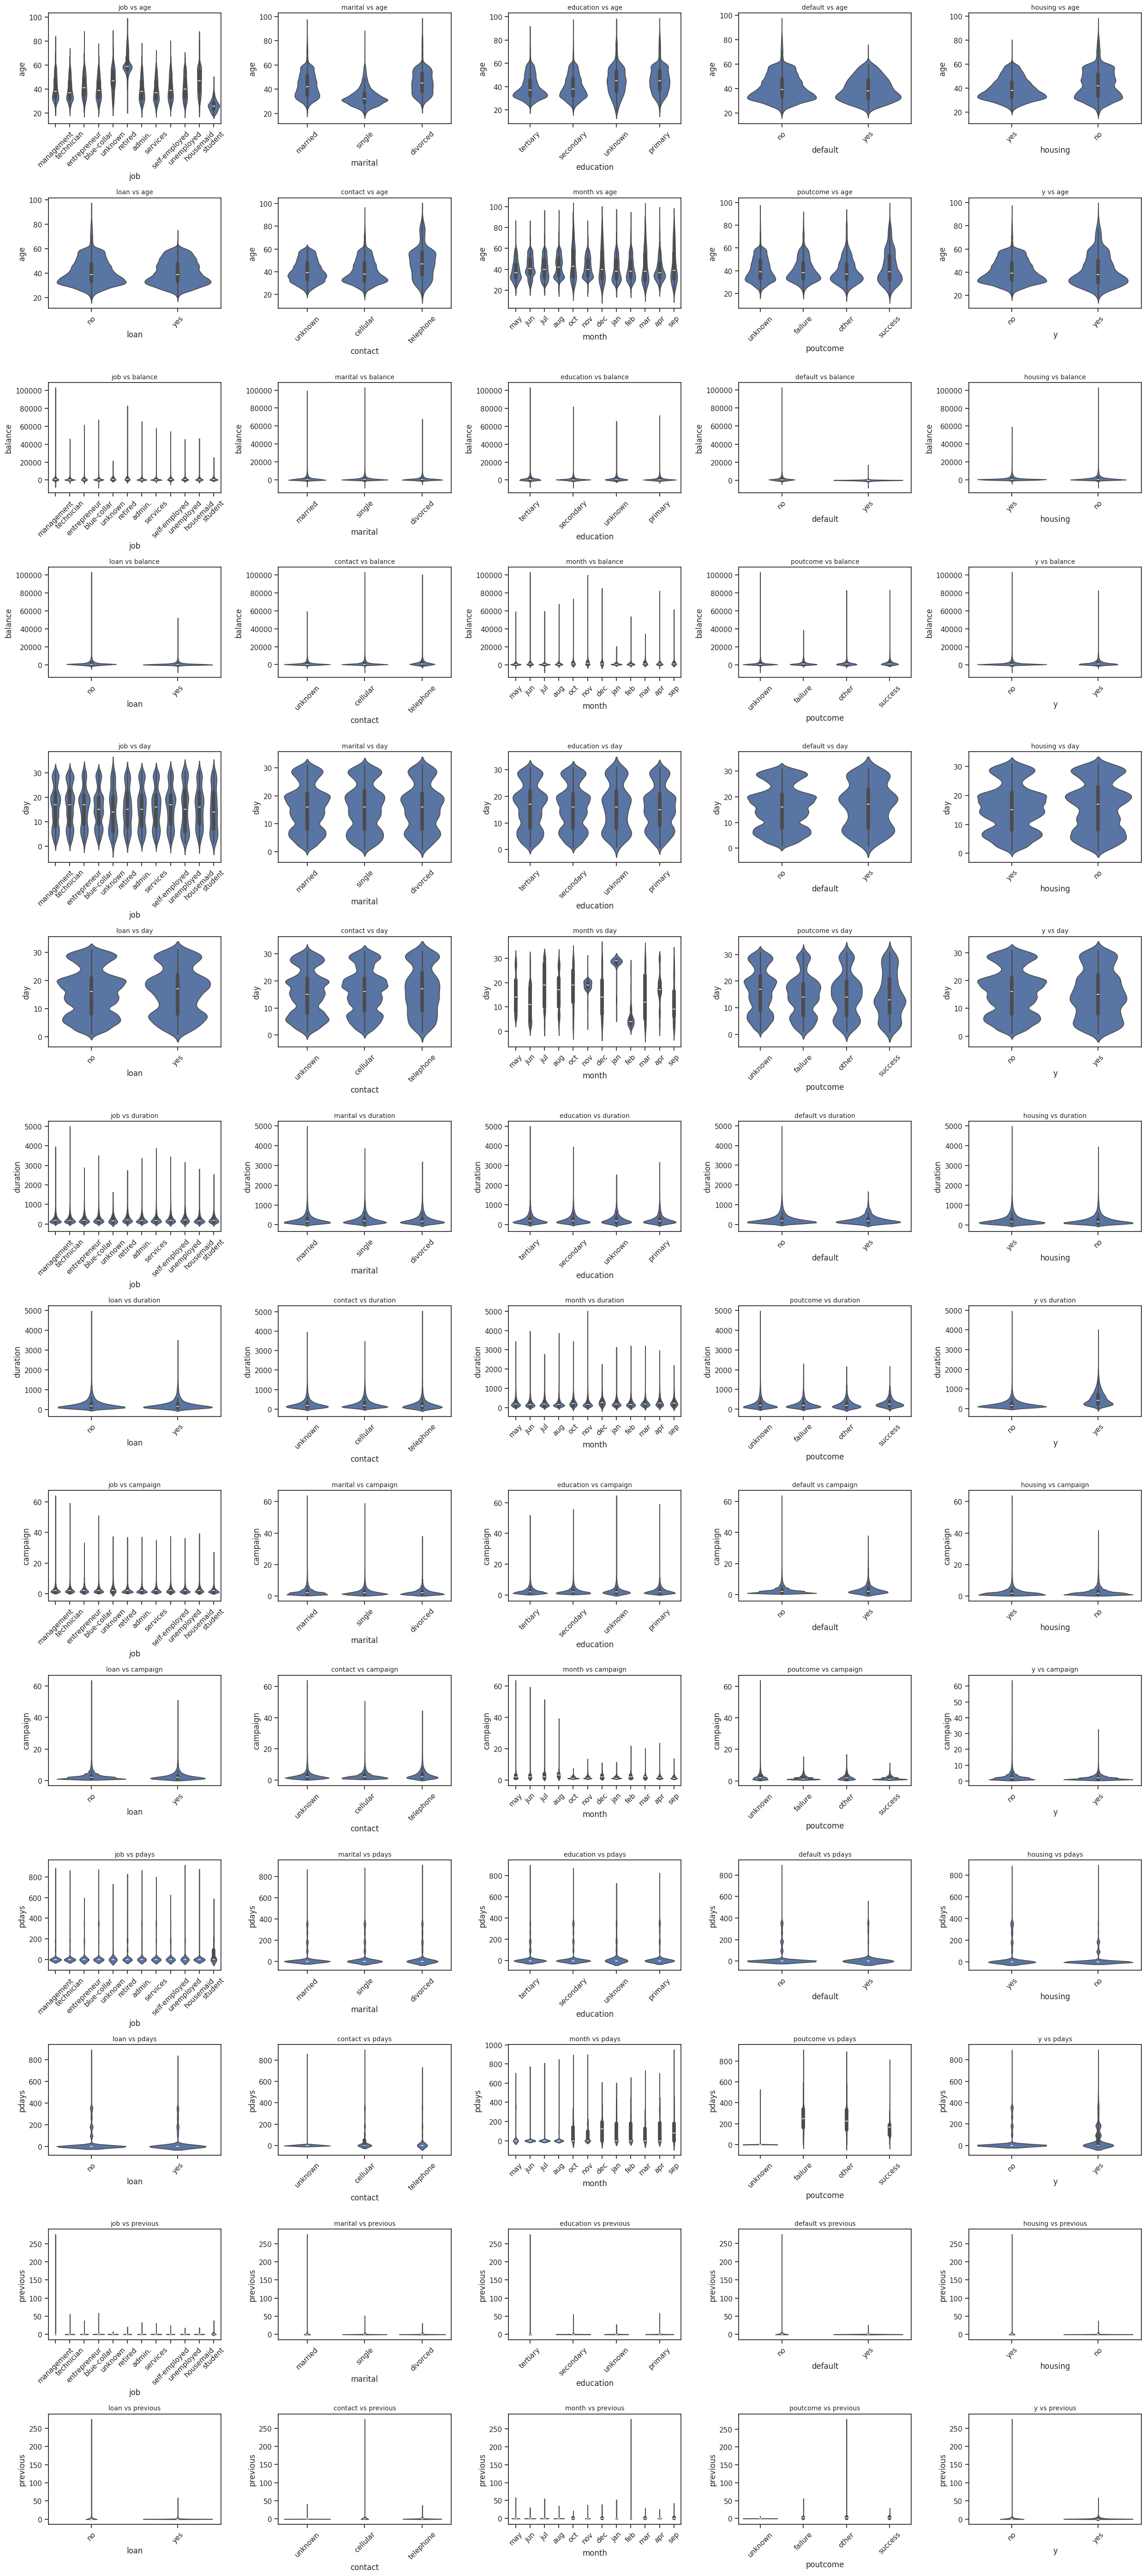

In [ ]:
plot_categorical_numerical_interactions(dataframe = dataframe)

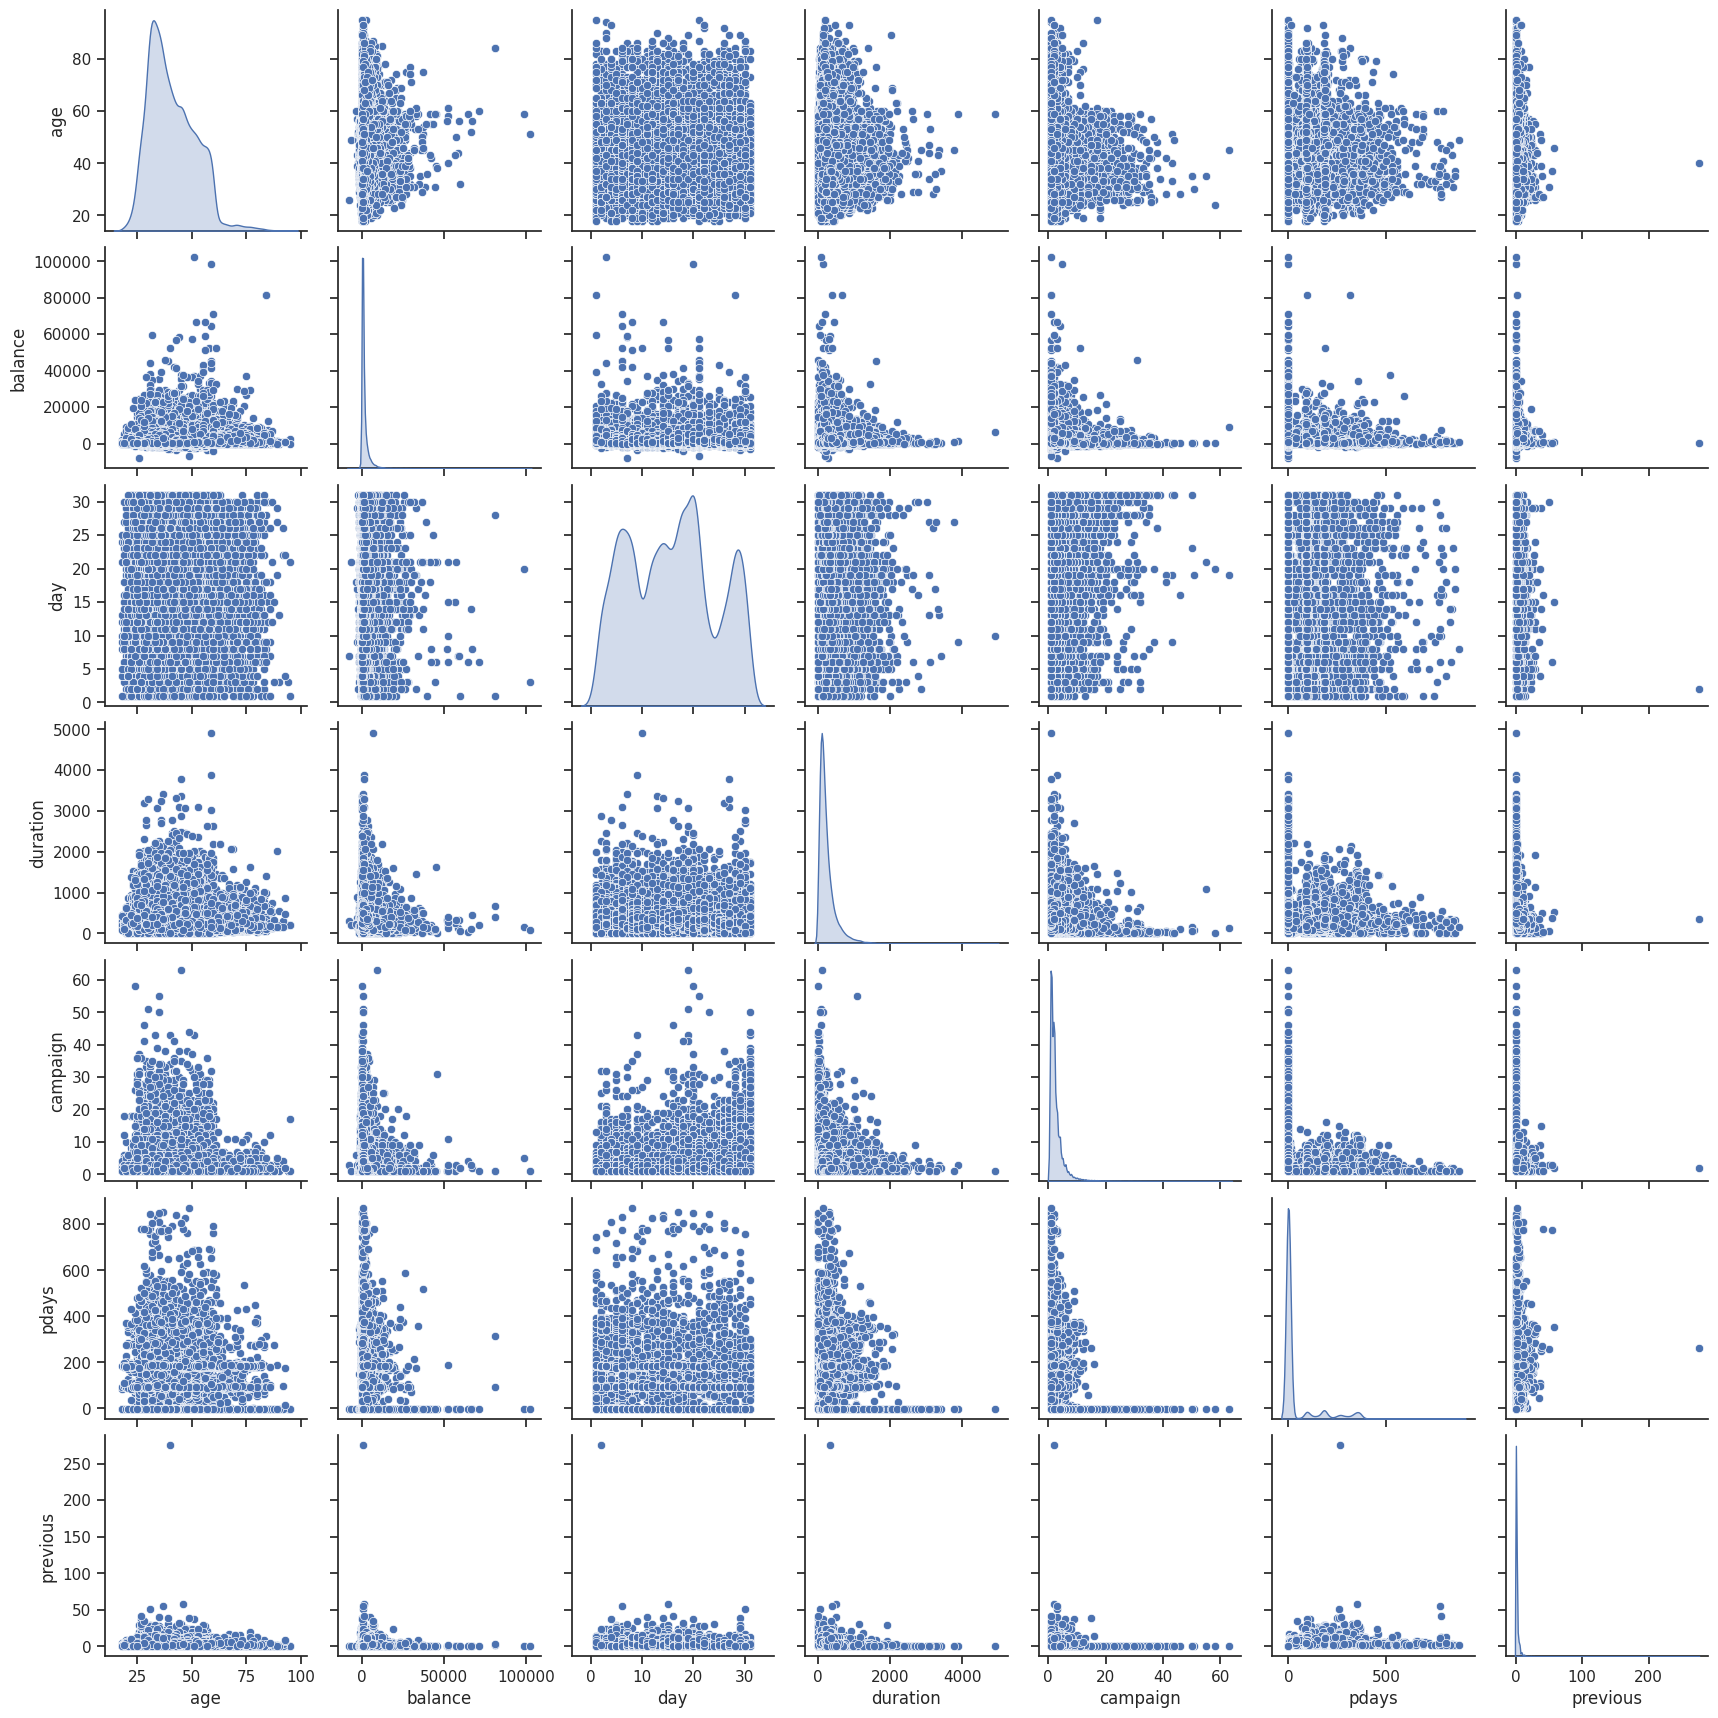

In [ ]:
scatterplot_matrix_numeric(dataframe = dataframe)

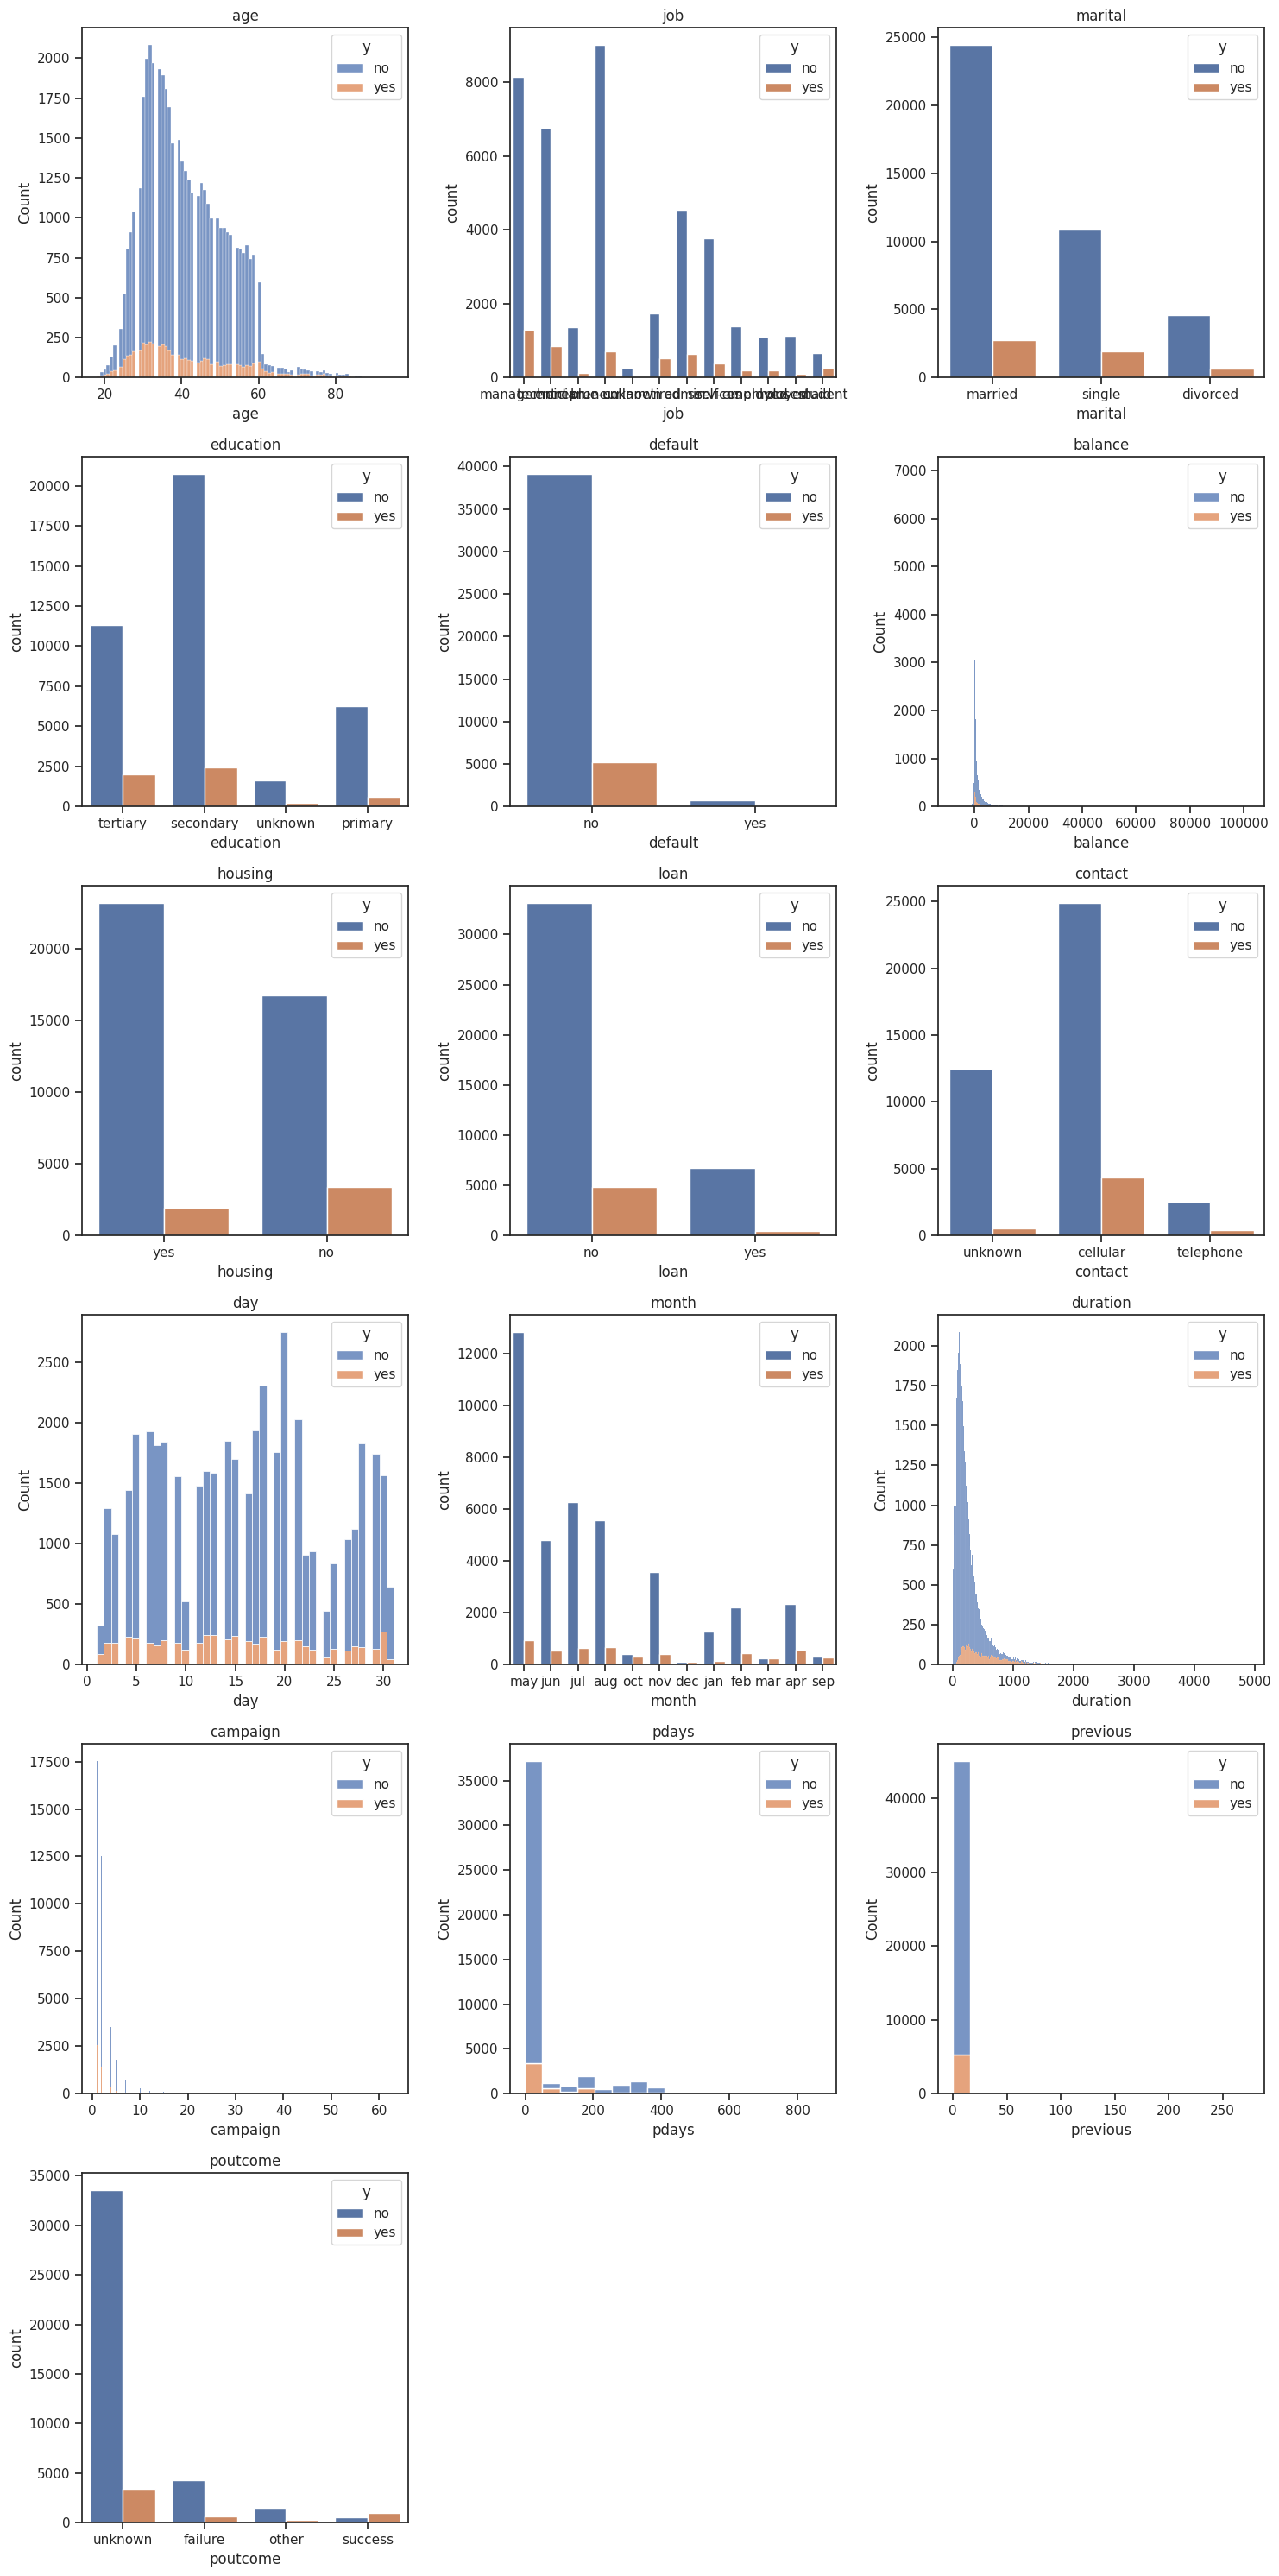

In [ ]:
features_vs_binary_target(dataframe = dataframe,target_variable = 'y')